In [1]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip3 install bitsandbytes transformers livelossplot matplotlib tqdm scikit-learn
# !pip3 install mixture-of-experts pydantic

In [3]:
import sys
sys.path.append('/mnt/c/Users/Arush Bansal/OneDrive - IIT Delhi/Desktop/arushGPT')


In [4]:
# from layers.RegexTokenizer import RegexTokenizer
import torch
from torch import nn
from torch.nn import functional as F
from torch.amp import autocast, GradScaler
import bitsandbytes as bnb

import time
from transformers import AutoTokenizer


from livelossplot import PlotLosses

from utils import ModelSpecs, TrainingData
from layers.Block import Block
# from layers.MLA_Block import Block
# from layers.WGQA_Block import Block
torch.manual_seed(1337)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
torch.__version__

'2.7.1+cu118'

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-3.5-mini-instruct")
# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
stories = TrainingData.TinyStories()

In [ ]:
# hyperparameters
modelSpecs = ModelSpecs.create('mid', VOCAB_SIZE=tokenizer.vocab_size)
# BATCH_SIZE = 38 # how many independent sequences will we process in parallel?
# BATCH_SIZE = 28 # how many independent sequences will we process in parallel?
BATCH_SIZE = 2 # how many independent sequences will we process in parallel?
MAX_ITERS = 2000
LEARNING_RATE = 3e-4
EVAL_INTERVALS = 100
# EVAL_ITERS = 200
EVAL_ITERS = 50
TRAIN_TEST_SPLIT = 0.9
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device.capitalize()} device.")


Running on Cuda device.


In [8]:
i = 8
text = stories[int(10**6 * 0.730612 * i):int(10**6 * 0.730612 *(i+1) )]
# text = TrainingData.TinyStories()[:int(10**6 * 0.730612 * 20 * 5)]
print(len(text)/10**6,"M")


0.730612 M


In [9]:

data = torch.tensor(tokenizer.encode(text))

n = int(TRAIN_TEST_SPLIT * len(data))
print(len(data)/10**6,"M")

train_data = data[:n]
val_data = data[n:]


Token indices sequence length is longer than the specified maximum sequence length for this model (184703 > 1024). Running this sequence through the model will result in indexing errors


0.184703 M


In [10]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - modelSpecs.BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([data[i:i+modelSpecs.BLOCK_SIZE] for i in ix])
    y = torch.stack([data[i+1:i+modelSpecs.BLOCK_SIZE+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [11]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(modelSpecs.VOCAB_SIZE, modelSpecs.N_EMBD)
        self.position_embedding_table = nn.Embedding(modelSpecs.BLOCK_SIZE, modelSpecs.N_EMBD)
        self.blocks = nn.Sequential(*[Block(modelSpecs) for _ in range(modelSpecs.N_LAYER)])
        self.ln_f = nn.LayerNorm(modelSpecs.N_EMBD) # final layer norm
        self.lm_head = nn.Linear(modelSpecs.N_EMBD, modelSpecs.VOCAB_SIZE)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -modelSpecs.BLOCK_SIZE:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [12]:
@torch.no_grad()
def estimate_loss(model : GPTLanguageModel):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            with autocast(device_type='cuda', dtype=torch.float16):
                _, loss = model(X, Y)
            # _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [13]:
m = GPTLanguageModel()
m = m.to(device)
# m = torch.compile(m, mode='default') # TODO use this when ready to use linux, and ready to train a 100M model
# m = torch.compile(m, backend='aot_eager')
# m = torch.compile(m, mode='reduce-overhead', backend='inductor') 
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
# optimizer = torch.optim.AdamW(m.parameters(), lr=LEARNING_RATE)
optimizer = bnb.optim.AdamW8bit(m.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()

49.386577 M parameters


In [14]:
# startTime = time.time()
# m.train()

# # torch.backends.cudnn.benchmark = True
# # torch.backends.cuda.matmul.allow_tf32 = True
# # torch.backends.cudnn.allow_tf32 = True

# # temporary line
# MAX_ITERS = 800 // BATCH_SIZE
# torch.cuda.empty_cache()
# iter99Str = ""
# iter99time = None
# ACCUMILATION = 2
# for iter in range(0, MAX_ITERS, ACCUMILATION):
#     print(f"iter #{iter}")
#     is_target_iter = (iter == ACCUMILATION)
#     # torch.cuda.empty_cache()
    
#     # every once in a while evaluate the loss on train and val sets
#     # if iter % EVAL_INTERVALS == 0 or iter == MAX_ITERS - 1:
#     #     losses = estimate_loss(model)
#         # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time {(time.time() - startTime)/60:.2f} minutes")
#         # print (f"step {iter}:  time {(time.time() - startTime)/60:.2f} minutes")
    
#     # torch.cuda.empty_cache()
#     # sample a batch of data
#     if is_target_iter : iter99time = time.time()

#     # evaluate the loss
#     optimizer.zero_grad(set_to_none=True)    

#     for i in range(ACCUMILATION):
#         # torch.compiler.cudagraph_mark_step_begin()
#         with autocast(device_type='cuda', dtype=torch.float16):
#             xb, yb = get_batch('train') 
#             logits, loss = m(xb, yb)
#         scaler.scale(loss/ ACCUMILATION).backward()

#     if is_target_iter :
#         print(f"forwardbackwardPass {time.time() - iter99time:.1f}s ", end="")
#         iter99time = time.time()
#     scaler.step(optimizer)
#     if is_target_iter :
#         print(f"backwardPassStep {time.time() - iter99time:.1f}s ", end="")
#         iter99time = time.time()

#     scaler.update()

#     if is_target_iter :
#         print(f"backwardPassUpdate {time.time() - iter99time:.1f}s")
#         iter99time = time.time()


# print(f"{torch.cuda.memory_allocated() / 1e6:.1f}MB {torch.cuda.max_memory_allocated() / 1e6:.1f}MB(peak) allocated, {torch.cuda.memory_reserved() / 1e6:.1f}MB reserved")


# endTime = time.time()
# print(f"Total Training Time : {(endTime - startTime)/60:.2f} minutes")

# torch.cuda.empty_cache()

In [15]:
# # import torch
# # from torch.cuda.amp import autocast, GradScaler
# # from livelossplot import PlotLosses
# # import time

# # ---------------------- CONFIG ----------------------
# ITERS = 100
# ACCUMULATION_STEPS = 2
# EVAL_INTERVALS = 20
# TRAIN_TEST_SPLIT = 0.9
# liveloss = PlotLosses()
# scaler = GradScaler()

# # ---------------------- TRAINING ----------------------
# startTime = time.time()
# step = BATCH_SIZE * modelSpecs.BLOCK_SIZE * ITERS * 8

# for story_start in range(989_593_600, len(stories), step):
#     print(f"\n=== OUTER ITER: {story_start // step} | STRING INDEX: {story_start} ===")
#     text = stories[story_start : story_start + step]
#     data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
#     n = int(TRAIN_TEST_SPLIT * len(data))
#     print(f"Tokens: {len(data)/1e6:.2f}M")

#     train_data, val_data = data[:n], data[n:]
#     del data
#     torch.cuda.empty_cache()

#     m.train()
#     MAX_ITERS = ITERS // ACCUMULATION_STEPS

#     for iter in range(MAX_ITERS):
#         iter_start = time.time()
#         is_profile_iter = (iter == ACCUMULATION_STEPS)  # for timing breakdown
        
#         optimizer.zero_grad(set_to_none=True)

#         # ---------------------- ACCUMULATED GRADIENTS ----------------------
#         for acc_step in range(ACCUMULATION_STEPS):
#             with autocast(device_type='cuda', dtype=torch.float16):
#                 xb, yb = get_batch('train')
#                 logits, loss = m(xb, yb)
#                 scaled_loss = loss / ACCUMULATION_STEPS
#             scaler.scale(scaled_loss).backward()

#         # ---------------------- OPTIMIZER STEP ----------------------
#         if is_profile_iter: t1 = time.time()
#         scaler.step(optimizer)
#         if is_profile_iter: 
#             print(f"Forward+Backward: {t1 - iter_start:.1f}s", end=" ")
#             t2 = time.time()
#         scaler.update()
#         if is_profile_iter:
#             print(f"Step: {t2 - t1:.1f}s Update: {time.time() - t2:.1f}s")

#         # ---------------------- EVAL + LOGGING ----------------------
#         if iter % EVAL_INTERVALS == 0 or iter == MAX_ITERS - 1:
#             torch.cuda.empty_cache()
#             losses = estimate_loss(m)
#             liveloss.update({'loss': losses['train'], 'val_loss': losses['val']})
#             liveloss.send()
#             elapsed = int((time.time() - startTime)//60)
#             print(f"\n[Eval] Iter {iter}/{MAX_ITERS} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | Time: {elapsed} min")
#             torch.cuda.empty_cache()

#     print(f"Outer Loop {story_start // step} done. Total Time: {(time.time() - startTime)/60:.2f} min\n")

# torch.cuda.empty_cache()
# print(f"Training Completed in {(time.time() - startTime)/60:.2f} minutes.")
# print(f"Memory: {torch.cuda.memory_allocated()/1e6:.1f}MB used, {torch.cuda.max_memory_allocated()/1e6:.1f}MB peak, {torch.cuda.memory_reserved()/1e6:.1f}MB reserved.")


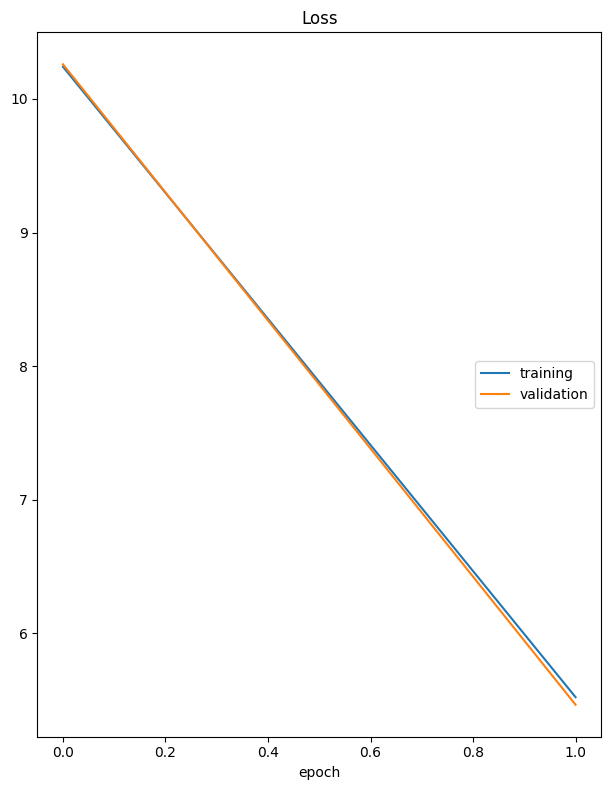

Loss
	training         	 (min:    5.523, max:   10.241, cur:    5.523)
	validation       	 (min:    5.466, max:   10.259, cur:    5.466)
[Eval] Iter 0/2000 | Train: 5.5230 | Val: 5.4663 | Time: 127.0 min
Training Progress:   0%|                             | 1/581 [01:16<8:54:06, 55.25s/it, slice=2/581]

In [ ]:
# import torch
# from torch.cuda.amp import autocast, GradScaler
# from livelossplot import PlotLosses
from tqdm import tqdm
# import time
import sys

# ---------------------- CONFIG ----------------------
ITERS = 100
ACCUMULATION_STEPS = 2
EVAL_INTERVALS = 100
TRAIN_TEST_SPLIT = 0.9
liveloss = PlotLosses()
scaler = GradScaler()

# ---------------------- TRAINING ----------------------
startTime = time.time()
step = BATCH_SIZE * modelSpecs.BLOCK_SIZE * ITERS * 8
outer_starts = list(range(0, len(stories), step))
num_outer_loops = len(outer_starts)

# tqdm progress bar for dataset coverage
pbar = tqdm(total=num_outer_loops, desc="Training Progress", ncols=100, file=sys.stdout)

for outer_idx, story_start in enumerate(outer_starts):
    pbar.set_postfix({"slice": f"{outer_idx+1}/{num_outer_loops}"})

    # Move tqdm bar before printing any normal logs
    pbar.refresh()
    print(f"\n=== OUTER ITER: {outer_idx+1}/{num_outer_loops} | STRING INDEX: {story_start} ===")

    text = stories[story_start : story_start + step]
    data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    n = int(TRAIN_TEST_SPLIT * len(data))
    print(f"Tokens: {len(data)/1e6:.2f}M")

    train_data, val_data = data[:n], data[n:]
    del data
    torch.cuda.empty_cache()

    m.train()

    for iter in range(0, ITERS, ACCUMULATION_STEPS):

        optimizer.zero_grad(set_to_none=True)

        # ----------- ACCUMULATED GRADIENTS -----------
        for _ in range(ACCUMULATION_STEPS):
            with autocast(device_type='cuda', dtype=torch.float16):
                xb, yb = get_batch('train')
                logits, loss = m(xb, yb)
                scaler.scale(loss / ACCUMULATION_STEPS).backward()

        # ----------- OPTIMIZER STEP -----------
        scaler.step(optimizer)
        scaler.update()
        # ----------- PERIODIC EVAL + LOGGING -----------
        if iter % EVAL_INTERVALS == 0 or iter == MAX_ITERS - 1:
            # torch.cuda.empty_cache()
            losses = estimate_loss(m)
            liveloss.update({'loss': losses['train'], 'val_loss': losses['val']})
            liveloss.send()
            elapsed = (time.time() - startTime)/60//0.01
            print(f"[Eval] Iter {iter}/{MAX_ITERS} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | Time: {elapsed} min")
            pbar.refresh()

    pbar.update(1)
    pbar.refresh()  # ensures the bar stays visible
    outer_elapsed = (time.time() - startTime)/60

pbar.close()
torch.cuda.empty_cache()
total_time = (time.time() - startTime)/60

print(f"\n✅ Training Completed in {total_time:.2f} minutes.")
print(f"Memory: {torch.cuda.memory_allocated()/1e6:.1f}MB used, "
      f"{torch.cuda.max_memory_allocated()/1e6:.1f}MB peak, "
      f"{torch.cuda.memory_reserved()/1e6:.1f}MB reserved.")


In [ ]:
# ITERS = 100
# startTime = time.time()
# step = BATCH_SIZE * modelSpecs.BLOCK_SIZE * ITERS * 8
# liveloss = PlotLosses()

# MAX_ITERS = 800 // BATCH_SIZE
# ACCUMILATION = 2

# # for i in range(step * 0, len(stories), step):
# for i in range(0, len(stories), step):
#     torch.cuda.empty_cache()
#     print("ITER:", i // step, "::::", " STRING INDEX:", i)
#     text = stories[i : i + step]
#     data = torch.tensor(tokenizer.encode(text))
#     n = int(TRAIN_TEST_SPLIT * len(data))
#     print("tokens", len(data)/10**6,"M")
#     train_data = data[:n]
#     val_data = data[n:]





#     for iter in range(ITERS):
#         print(f"iter #{iter}")
        
#         # every once in a while evaluate the loss on train and val sets
#         if iter % EVAL_INTERVALS == 0 or iter == ITERS - 1:
#             losses = estimate_loss(m)
#             liveloss.update({ 'loss': losses['train'], 'val_loss': losses['val']})
#             liveloss.send()
#             print("ITER:", i // step, "::::", " STRING INDEX:", i)
#             print("tokens", len(data)/10**6,"M")
#             print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time {int((time.time() - startTime)//60)} minutes")

#         # sample a batch of data
#         xb, yb = get_batch('train')

#         # evaluate the loss
#         logits, loss = m(xb, yb)
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()

#     endTime = time.time()
#     print(f"Total Training Time : {int((endTime - startTime)//60)} minutes")

In [ ]:
# 100M BATCH 8 BLOCK 512 16.77min 56.86days-for-2B-tokens
# 100M BATCH 8 BLOCK 512 11.82min 40.07days-for-2B-tokens 1654MB 7756MB (peak) allocated 8512MB reserved

# 22.2s
#10.2s

In [ ]:
print(torch.backends.cuda.flash_sdp_enabled())       # should be True
print(torch.backends.cuda.mem_efficient_sdp_enabled()) # True
print(torch.backends.cuda.math_sdp_enabled())          # True

True
True
True


In [ ]:
# WGQA-8 16 head 16 layer - perplexity implimentation (95M param)
# 1412.382208 MB allocated
# 8919.369216 MB peak allocated
# 9753.853952 MB reserved
# Total Training Time : 12.06 minutes

# WGQA-8 16 head 18 layer - perplexity implimentation (95M param)
# 1412.382208 MB allocated
# 8919.369216 MB peak allocated
# 9753.853952 MB reserved
# Total Training Time : 12.06 minutes

# WGQA-8 16 head 18 layer - perplexity implimentation (103M param)
# 1470.321152 MB allocated
# 10227.390976 MB peak allocated
# 10525.605888 MB reserved
# Total Training Time : 15.58 minutes

# MLA 16 head 8 layer - 103M param (76M param)
# 1696.742912 MB allocated
# 6963.769856 MB peak allocated
# 7746.879488 MB reserved
# Total Training Time : 4.31 minutes



In [ ]:
# MHA 516Embed 12Heads 16Layers :aot_eager 
# 1702.7MB 7804.9MB(peak) allocated 8638.1MB reserved
# Total Training Time : 13.01 minutes

# MHA 516Embed 12Heads 16Layers :default 
# 1695.1MB 5558.3MB(peak) allocated, 5893.0MB reserved
# Total Training Time : 16.79 minutes

# MHA 516Embed 12Heads 16Layers :reduce-overhead:inductor 
# forwardPass 0.0s backwardPassScale 0.0s backwardPassStep 6.2s backwardPassUpdate 0.0s
# 832.5MB 5885.0MB(peak) allocated, 6341.8MB reserved
# Total Training Time : 15.12 minutes

# MHA 516Embed 12Heads 16Layers :gradient-accumilation
# BATCH 16 ITER 100 ACCUMILATION 1 : ~16min
# BATCH 16 ITER 100 ACCUMILATION 2 : OOM Error
# BATCH 08 ITER 200 ACCUMILATION 2 : 6.54min 1423.5MB 5743.7MB(peak) allocated, 6157.2MB reserved
# BATCH 08 ITER 200 ACCUMILATION 4 : 6.89min 1423.5MB 5743.7MB(peak) allocated, 6157.2MB reserved
# BATCH 08 ITER 200 ACCUMILATION 8 : ~7min forwardbackwardPass 16.8s backwardPassStep 0.3s backwardPassUpdate 0.0s

# iter #99
# 802.5MB 5817.1MB(peak) allocated, 6178.2MB reserved
# Total Training Time : 9.90 minutes

# MHA 512Embed 12Heads 16Layers :gradient-accumilation :
# no-sqda 5.27min forwardbackwardPass 2.8s backwardPassStep 0.1s backwardPassUpdate 0.0s 1448.4MB 4803.8MB(peak) allocated, 5207.2MB reserved
# sqda 6.19 minutes 1448.4MB 4845.2MB(peak) allocated, 5677.0MB reserved] 

# 1345.5MB 3120.2MB(peak) allocated, 3741.3MB reserved
# Total Training Time : 6.47 minutes

# Batch size 2 accumilation 2 mla block size 512 embed 516
# 1306.3MB 3028.1MB(peak) allocated, 3231.7MB reserved
# Total Training Time : 1.24 minutes


# MLA batch 4 accumilation 2 mla block size 512 embed 516
# forwardbackwardPass 2.0s backwardPassStep 0.1s backwardPassUpdate 0.0s
# BATCH_SIZE = 4

# MLA batch 2 accumlation mla block size 512 embed 516
# forwardbackwardPass 0.7s backwardPassStep 0.1s backwardPassUpdate 0.0s
# 1301.0MB 3025.9MB(peak) allocated, 3439.3MB reserved
# Total Training Time : 1.12 minutes

# MLA batch 1 accumlation 8 mla block size 512 embed 516
# forwardbackwardPass 1.0s backwardPassStep 0.1s backwardPassUpdate 0.0s
# 1159.5MB 2099.8MB(peak) allocated, 2300.6MB reserved
# Total Training Time : 1.62 minutes

# MLA batch 1 accumlation 4 mla block size 512 embed 516
# forwardbackwardPass 0.5s backwardPassStep 0.1s backwardPassUpdate 0.0s
# 1159.2MB 2094.4MB(peak) allocated, 2300.6MB reserved
# Total Training Time : 1.69 minutes

In [ ]:
# input_tokens = torch.tensor(tokenizer.encode("there was once a forest with 100s of bushes")).unsqueeze(0).cuda()
input_tokens = torch.tensor(tokenizer.encode('who is the fastest')).unsqueeze(0).cuda()
# print(input_tokens)

m.eval()

output_tokens = m.generate(input_tokens, max_new_tokens=64)[0]
# print(output_tokens)

m.train()

output : str = tokenizer.decode(output_tokens)


print(output)

who is the fastest!" Anna says.

They nod. They say, " arc! winning is to vanish! One way is where you are and where you are going."

The sun starts to dry. Anna and Ben are sad. They want to see the prettiest thing. They look for looks.

They see


In [ ]:
print(int(len(stories)//(10**6 )))

1902


In [ ]:
# ITERS = 100
# startTime = time.time()
# step = BATCH_SIZE * modelSpecs.BLOCK_SIZE * ITERS * 8
# liveloss = PlotLosses()

# # for i in range(step * 0, len(stories), step):
# for i in range(989593600, len(stories), step):
#     print("ITER:", i // step, "::::", " STRING INDEX:", i)
#     text = stories[i : i + step]
#     data = torch.tensor(tokenizer.encode(text))
#     n = int(TRAIN_TEST_SPLIT * len(data))
#     print("tokens", len(data)/10**6,"M")

#     train_data = data[:n]
#     val_data = data[n:]





#     for iter in range(ITERS):
#         print(f"iter #{iter}")
#         torch.cuda.empty_cache()
#         # every once in a while evaluate the loss on train and val sets
#         if iter % EVAL_INTERVALS == 0 or iter == ITERS - 1:
#             losses = estimate_loss(m)
#             liveloss.update({ 'loss': losses['train'], 'val_loss': losses['val']})
#             liveloss.send()
#             print("ITER:", i // step, "::::", " STRING INDEX:", i)
#             print("tokens", len(data)/10**6,"M")
#             print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time {int((time.time() - startTime)//60)} minutes")
            
#         torch.cuda.empty_cache()
#         # sample a batch of data
#         xb, yb = get_batch('train')

#         # evaluate the loss
#         logits, loss = m(xb, yb)
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()

#     endTime = time.time()
#     print(f"Total Training Time : {int((endTime - startTime)//60)} minutes")

In [ ]:
655,360,000
989,593,600

(989, 593, 600)

In [ ]:
input_tokens = torch.tensor(tokenizer.encode(" ")).unsqueeze(0).cuda()
# print(input_tokens)


output_tokens = m.generate(input_tokens, max_new_tokens=100)[0]
# print(output_tokens)

output : str = tokenizer.decode(output_tokens)



print(output)


In [ ]:

def convert_optimizer_state_to_float32(optimizer : torch.optim.AdamW):
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor) and v.dtype == torch.float64:
                state[k] = v.float()


# Saving the model
def save_model(model : nn.Module, optimizer : torch.optim.AdamW, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

# Loading the model
def load_model(model : nn.Module, optimizer : torch.optim.AdamW, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    convert_optimizer_state_to_float32(optimizer)

    print(f"Model loaded from {filepath}")
    model.to(device)
    return model, optimizer





In [ ]:
# # Save after training
# save_model(m, optimizer, 'weights/gpt_model_50M.pth') # TODO improve this naming convention

# # Later or for inference
# # model = GPTLanguageModel()
# # optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# # model, optimizer = load_model(model, optimizer, 'gpt_model_checkpoint.pth', device)


In [ ]:
# pre_model = GPTLanguageModel()
# pre_optimizer = torch.optim.AdamW(pre_model.parameters(), lr=LEARNING_RATE)

# loaded_model, loaded_optimizer = load_model(pre_model, pre_optimizer, './weights/gpt_model_50M.pth', device)


In [ ]:
# loaded_model = loaded_model.cuda()

In [ ]:
# ITERS = 100
# startTime = time.time()
# step = BATCH_SIZE * modelSpecs.BLOCK_SIZE * ITERS * 8
# liveloss = PlotLosses()

# # for i in range(step * 0, len(stories), step):
# for i in range(989593600, len(stories), step):
#     print("ITER:", i // step, "::::", " STRING INDEX:", i)
#     text = stories[i : i + step]
#     data = torch.tensor(tokenizer.encode(text))
#     n = int(TRAIN_TEST_SPLIT * len(data))
#     print("tokens", len(data)/10**6,"M")

#     train_data = data[:n]
#     val_data = data[n:]





#     for iter in range(ITERS):
#         print(f"iter #{iter}")
#         torch.cuda.empty_cache()
#         # every once in a while evaluate the loss on train and val sets
#         if iter % EVAL_INTERVALS == 0 or iter == ITERS - 1:
#             losses = estimate_loss(loaded_model)
#             liveloss.update({ 'loss': losses['train'], 'val_loss': losses['val']})
#             liveloss.send()
#             print("ITER:", i // step, "::::", " STRING INDEX:", i)
#             print("tokens", len(data)/10**6,"M")
#             print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time {int((time.time() - startTime)//60)} minutes")
#         torch.cuda.empty_cache()
#         # sample a batch of data
#         xb, yb = get_batch('train')

#         # evaluate the loss
        
#         logits, loss = loaded_model(xb, yb)
#         loaded_optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         loaded_optimizer.step()

#     endTime = time.time()
#     print(f"Total Training Time : {int((endTime - startTime)//60)} minutes")

In [ ]:
# input_tokens = torch.tensor(tokenizer.encode(" ")).unsqueeze(0).cuda()
# # print(input_tokens)


# output_tokens = loaded_model.generate(input_tokens, max_new_tokens=100)[0]
# # print(output_tokens)

# output : str = tokenizer.decode(output_tokens)



# print(output)
